### Exercise 5

#### Task 1

**Follow the example from**

https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

Import libraries

In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load seaborn "flights" dataset

In [2]:
flight_data = sns.load_dataset("flights")
print(flight_data.shape)
flight_data.head()

(144, 3)


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


Plot frequency of passengers per month.

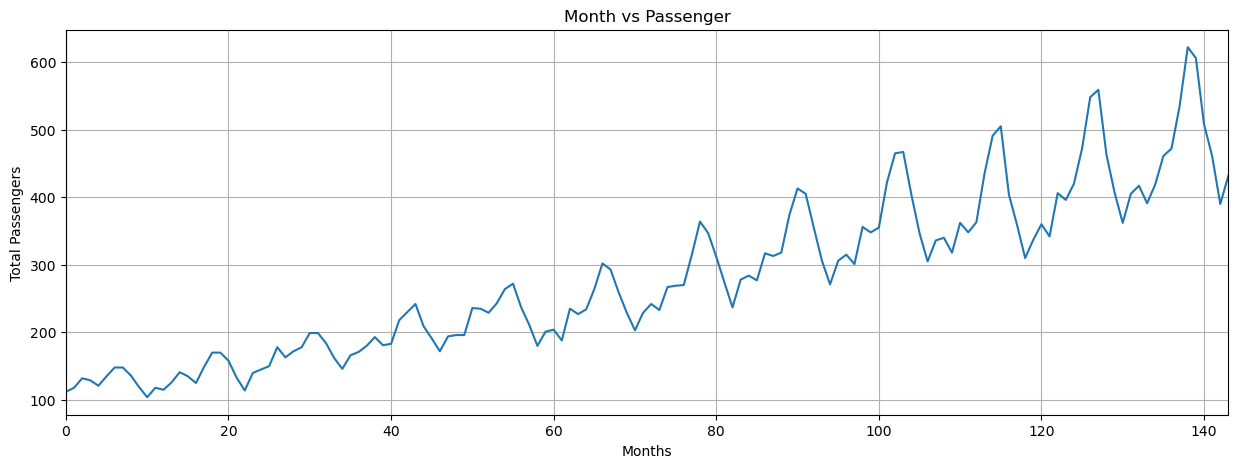

In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

Preprocess data and split into train and test sets

In [4]:
all_data = flight_data['passengers'].values.astype(float)

test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

Normalize data using min max scaler.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

Convert dataset into tensors.

In [6]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

define a function named create_inout_sequences. The function will accept the raw input data and will return a list of tuples.

In [7]:
train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

Create LSTM model

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, pre_linear_size=64, hidden_layer_size=400, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.pre_linear = nn.Linear(input_size, pre_linear_size)
        self.pre_liner2 = nn.Linear(pre_linear_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        input_seq = input_seq.view(len(input_seq), 1, -1)
        input_seq = self.pre_linear(input_seq)
        input_seq = self.pre_liner2(input_seq)
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

Define loss function and optimizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM().to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train the model

In [10]:
epochs = 150
for i in range(epochs):
    for seq, labels in train_inout_seq:
        seq = seq.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000001
epoch:  26 loss: 0.00002705
epoch:  51 loss: 0.00926345
epoch:  76 loss: 0.00008713
epoch: 101 loss: 0.00375968
epoch: 126 loss: 0.00041679
epoch: 149 loss: 0.0000053421


Make predictions

In [11]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

model.eval()

model.hidden = (torch.zeros(2, 1, model.hidden_layer_size),
                torch.zeros(2, 1, model.hidden_layer_size))
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
    with torch.no_grad():
        test_inputs.append(model(seq).item())

test_inputs[fut_pred:]

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


[0.5458899140357971,
 0.7127202749252319,
 0.5872664451599121,
 0.4920886754989624,
 0.4358826279640198,
 0.5341627597808838,
 0.837367594242096,
 1.013644814491272,
 0.6026031374931335,
 0.38301753997802734,
 0.22800317406654358,
 0.40932831168174744]

Convert into actual values using inverse_transform

In [12]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[455.68995544]
 [493.64386255]
 [465.10311627]
 [443.45017368]
 [430.66329786]
 [453.02202785]
 [522.00112769]
 [562.1041953 ]
 [468.59221378]
 [418.63649035]
 [383.3707221 ]
 [424.62219091]]


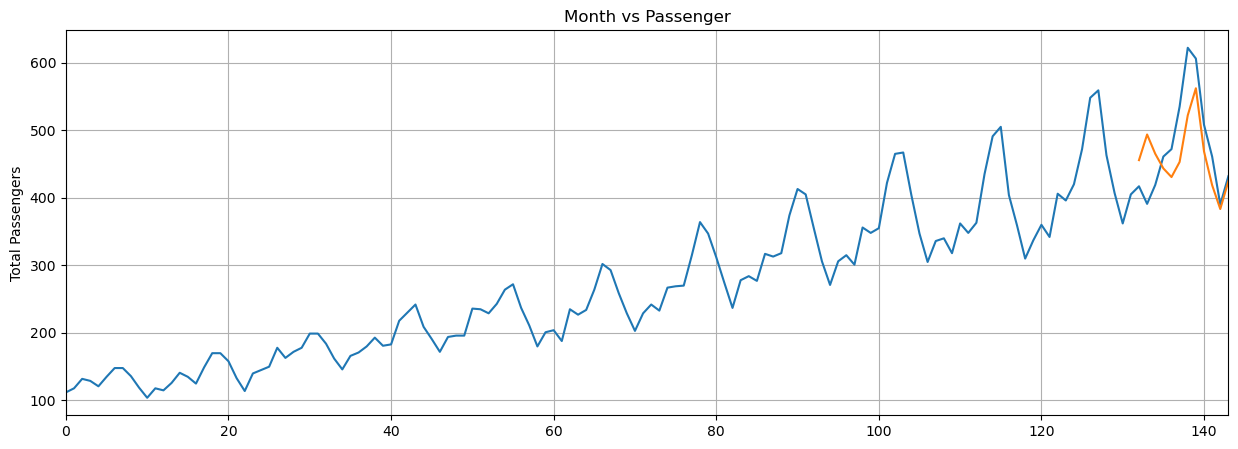

In [13]:
x = np.arange(132, 144, 1)

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

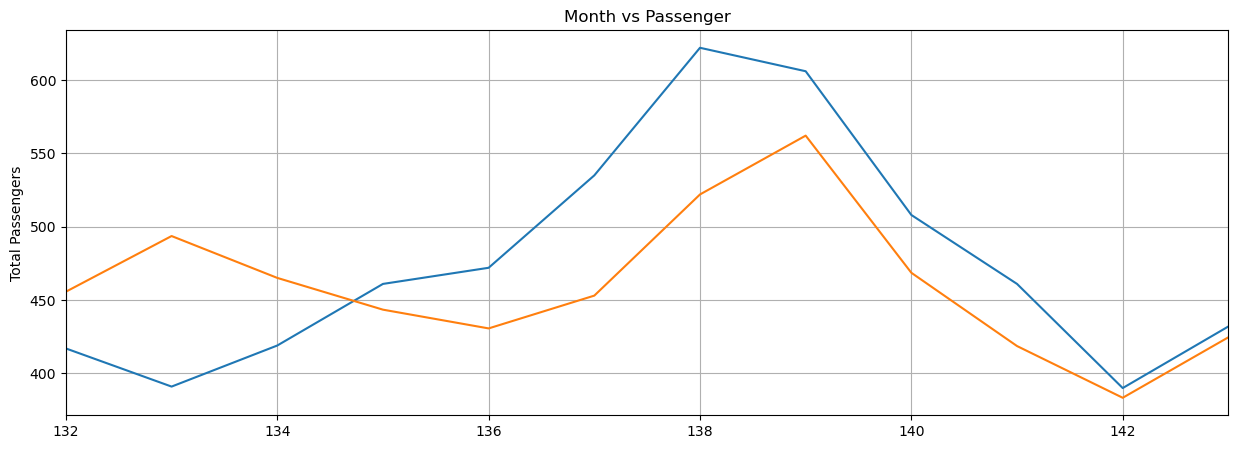

In [14]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

Model is now predicting more accurate results and is able to capture seasonal change. The first plot shows in the orange colour that the line mimics the actual data. This is better than the original which is below. 

Two linear layers (pre_linear in the code) with size of 64 was added to the architecture before the lstm layer. Second pre linear layer returns the size to the size of input for lstm. Hidden_layer_size was increased from 100 to 400, which was tested by trial and error. Higher values are not able to catch the peak of the trend.

Results with original model:

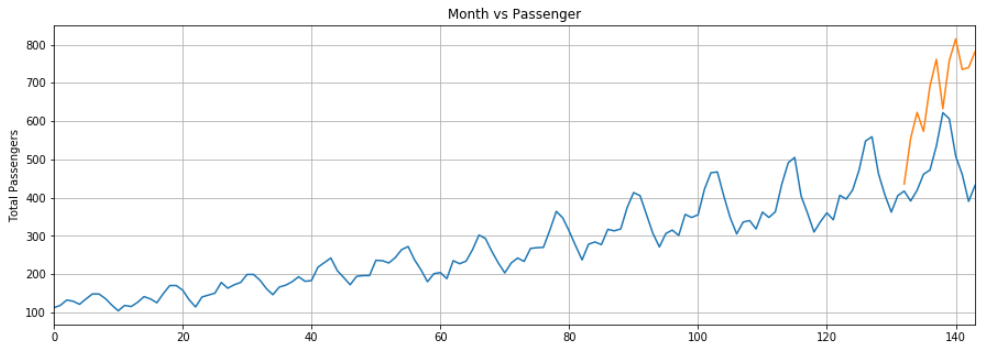
image from https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf

#### Task 2

**Run the code from link: https://charlieoneill11.github.io/charlieoneill/python/lstm/pytorch/2022/01/14/lstm2.html**

Code is applied for nvidia stock data. Data is stored in nvda_data.csv, which contain the last 3kk daily values from 18.9. - 18.12.2024. Downloaded from Investing.com. 


Import libraries

In [15]:
import pandas as pd

Load the data and preprocess

In [16]:
# Load the data
df = pd.read_csv('nvda_data_6y.csv', index_col='Päivämäärä\r', parse_dates=True, dayfirst=True)
# convert , to . in the in all the columns
df = df.rename(columns={'Viim.':'Close', 'Avoin':'Open', 'Korkea':'High', 'Matala\r':'Low', 'Vol.':'Volume'})
df = df.rename_axis('Date')
df['Close'] = df['Close'].str.replace(',','.').astype(float)
df['Open'] = df['Open'].str.replace(',','.').astype(float)
df['High'] = df['High'].str.replace(',','.').astype(float)
df['Low'] = df['Low'].str.replace(',','.').astype(float)

# Handle 'Volume' column with 'M' and 'B' suffixes
def convert_volume(volume):
	if 'K' in volume:
		return float(volume.replace('K', '').replace(',', '.')) * 1e3
	elif 'M' in volume:
		return float(volume.replace('M', '').replace(',', '.')) * 1e6
	elif 'B' in volume:
		return float(volume.replace('B', '').replace(',', '.')) * 1e9

df['Volume'] = df['Volume'].apply(convert_volume)
df.drop(columns='Muut.%', inplace=True)
# sort the data based on date
df = df.sort_values(by='Date')
print(len(df))
df

1511


,Close,Open,High,Low,Volume
Date,,,,,
2018-12-18,3.67,3.63,3.76,3.61,564370000.0
2018-12-19,3.46,3.64,3.69,3.41,745370000.0
2018-12-20,3.38,3.45,3.54,3.32,749590000.0
2018-12-21,3.24,3.40,3.44,3.21,863740000.0
2018-12-24,3.18,3.16,3.25,3.11,463840000.0
...,...,...,...,...,...
2024-12-12,137.34,137.08,138.44,135.80,159210000.0
2024-12-13,134.25,138.94,139.60,132.54,231510000.0
2024-12-16,132.00,134.18,134.40,130.42,237950000.0


We are going to use column 'Close', which is the last stock price given day.

Plot price over time

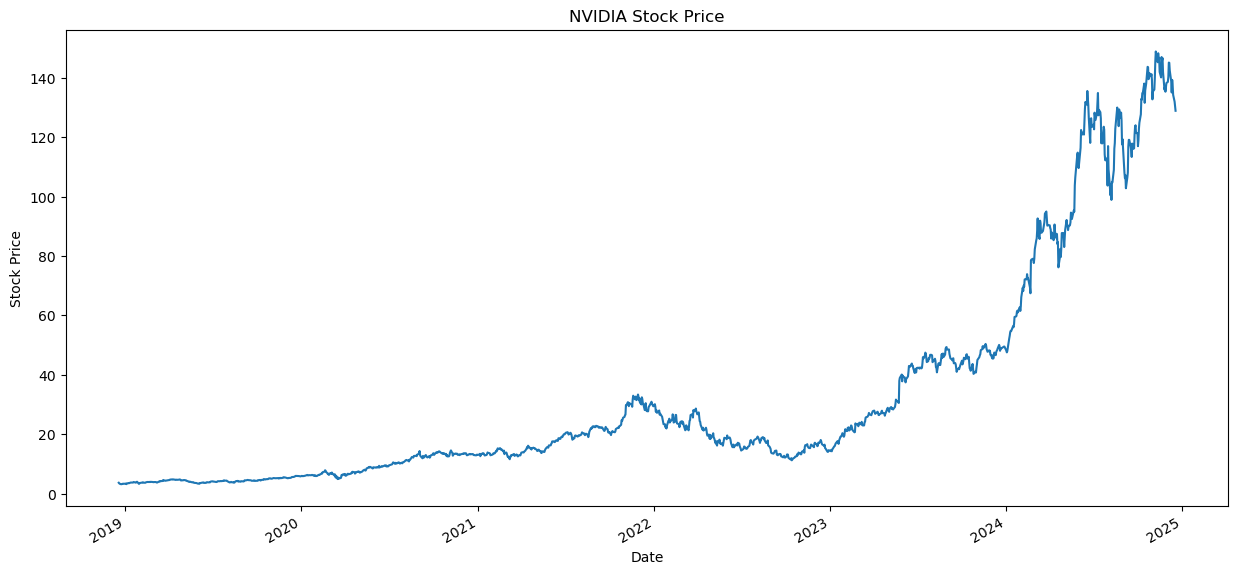

In [17]:
df['Close'].plot(figsize=(15, 7))
plt.ylabel("Stock Price")
plt.title("NVIDIA Stock Price")
plt.show()

Extract X and y

In [18]:
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((1511, 4), (1511,))

Normalize sets

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

Instead of feeding 100 samples, use 20 and look for the next 7 step values.

In [20]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(1363, 100, 4) (1363, 50)


In [21]:
y_mm[0]

array([0.00535347, 0.00597117, 0.00555937, 0.005628  , 0.0050103 ,
       0.00418668, 0.00480439, 0.00432395, 0.00343171, 0.00308854,
       0.00274537, 0.00226493, 0.00205903, 0.00144132, 0.00109815,
       0.00274537, 0.0024022 , 0.002814  , 0.00315717, 0.00363761,
       0.00404942, 0.00322581, 0.00363761, 0.0030199 , 0.00308854,
       0.00439259, 0.00446122, 0.00459849, 0.00418668, 0.00439259,
       0.00418668, 0.00549073, 0.00617708, 0.00638298, 0.00665752,
       0.00603981, 0.00610844, 0.00569664, 0.00514756, 0.00514756,
       0.005628  , 0.00672615, 0.00693205, 0.00686342, 0.00686342,
       0.00727522, 0.00734386, 0.00706932, 0.00754976, 0.00830474])

In [22]:
y_trans[99:149].squeeze(1)

array([0.00535347, 0.00597117, 0.00555937, 0.005628  , 0.0050103 ,
       0.00418668, 0.00480439, 0.00432395, 0.00343171, 0.00308854,
       0.00274537, 0.00226493, 0.00205903, 0.00144132, 0.00109815,
       0.00274537, 0.0024022 , 0.002814  , 0.00315717, 0.00363761,
       0.00404942, 0.00322581, 0.00363761, 0.0030199 , 0.00308854,
       0.00439259, 0.00446122, 0.00459849, 0.00418668, 0.00439259,
       0.00418668, 0.00549073, 0.00617708, 0.00638298, 0.00665752,
       0.00603981, 0.00610844, 0.00569664, 0.00514756, 0.00514756,
       0.005628  , 0.00672615, 0.00693205, 0.00686342, 0.00686342,
       0.00727522, 0.00734386, 0.00706932, 0.00754976, 0.00830474])

Split into train and test sets

In [23]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (1213, 100, 4) (1213, 50)
Testing Shape: (150, 100, 4) (150, 50)


Convert data into tensors

In [24]:
from torch.autograd import Variable

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

Reshape tensors

In [25]:
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2]))  

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([1213, 100, 4]) torch.Size([1213, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


Check that values match 

In [26]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[9.4370e+01, 9.4740e+01, 9.1810e+01, 3.5969e+08],
       [9.3750e+01, 9.5200e+01, 9.3440e+01, 3.1876e+08],
       [9.3600e+01, 9.5400e+01, 9.3180e+01, 3.2895e+08],
       [9.5460e+01, 9.6020e+01, 9.3250e+01, 5.4865e+08]])

In [27]:
X.iloc[-149:-145]

,Open,High,Low,Volume
Date,,,,
2024-05-17,94.37,94.74,91.81,359690000.0
2024-05-20,93.75,95.20,93.44,318760000.0
2024-05-21,93.60,95.40,93.18,328950000.0
2024-05-22,95.46,96.02,93.25,548650000.0


LSTM model

In [28]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.pre_linear = nn.Linear(input_size, 64)
        self.pre_liner2 = nn.Linear(64, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 256) # fully connected 
        self.fc_2 = nn.Linear(256, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.pre_linear(x)
        x = self.pre_liner2(x)
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # hidden state

        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # cell state
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

Training loop

In [29]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):

        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [30]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 64 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.03475, test loss: 0.61011
Epoch: 100, train loss: 0.00089, test loss: 0.00969
Epoch: 200, train loss: 0.00065, test loss: 0.01049
Epoch: 300, train loss: 0.00041, test loss: 0.02142
Epoch: 400, train loss: 0.00031, test loss: 0.02808
Epoch: 500, train loss: 0.00018, test loss: 0.03363
Epoch: 600, train loss: 0.00014, test loss: 0.02976
Epoch: 700, train loss: 0.00010, test loss: 0.03047
Epoch: 800, train loss: 0.00009, test loss: 0.03036
Epoch: 900, train loss: 0.00007, test loss: 0.03124


Results

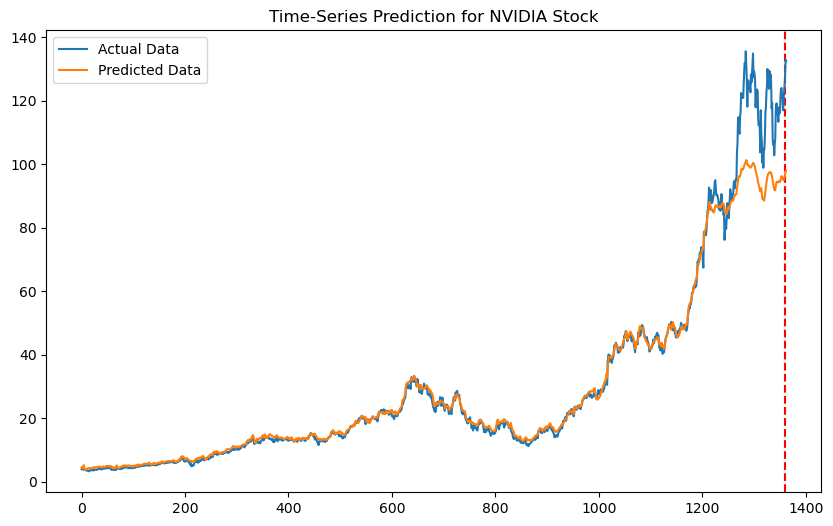

In [31]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction for NVIDIA Stock')
plt.legend()
plt.show() 

feed the 100 time-steps of features before the final value in the test set, and then use one model forward pass to calculate the 50 time-step prices in the test set. Plot results.

In [32]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

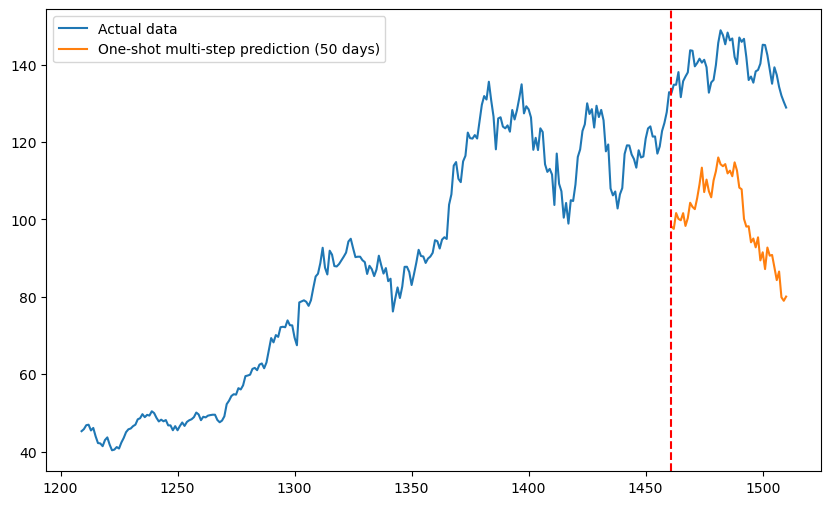

In [34]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(1209, len(y))]
plt.plot(a, y[1209:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()

The NVIDIA stock data fails to predict the last bull run after 1200 samples, which leads to insufficient one-shot multi-step prediction.

Architecture was optimized by adding two linear layers before LSTM layer and latter layer sizes were increased from 128 -> 256. Hidden layer size was increased from 2 -> 64. 

**Verbally:**

**⦁ Explain exactly what the multivariate data represents in input and what the LSTM network tries to predict?**


Multivariate data represents multiple features as input for the model. For this stock data, each feature is a time series and they are Daily Open, High and Low prices and Volume. LSTM model tries to predict the Close price, which is set to y. The model mimics well the Close prices to 1200 samples, which is due to data leakage as it is presented in the tutorial. Since one of the input features is Open price, the model always knows the price of the day. The last plot is prediction to the last day of training set and shows model predictions for the last 50 days without knowing the Open prices.

**⦁ Does this dataset have any internal correlation?**

Dataset contains internal correlation. There are correlation between Open, High and Low prices. They have affect to other days. Also Volume has correlation with daily prices, since high volume may indicate larger gap between High and Low prices or between Open and High/Low prices. Prices have correlation to time series since multiple increasing values may indicate bullish or bearish market. These trends may be even better captured using additional feature Moving averages.

In [35]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(dataY_plot, data_predict)
print("Mean Squared Error:", mse)

Mean Squared Error: 79.05211


Below is results using the original architecture from the tutorial. The improvement can be seen as slightly better results for orange line in the Time Series prediction image. In both models, the prediction for the extremely bullish trend is difficult to predict. 

Modified code Mean Squared Error: 79.05211, which indicate better and more reliable results.

Original Mse error Mean Squared Error: 127.902626

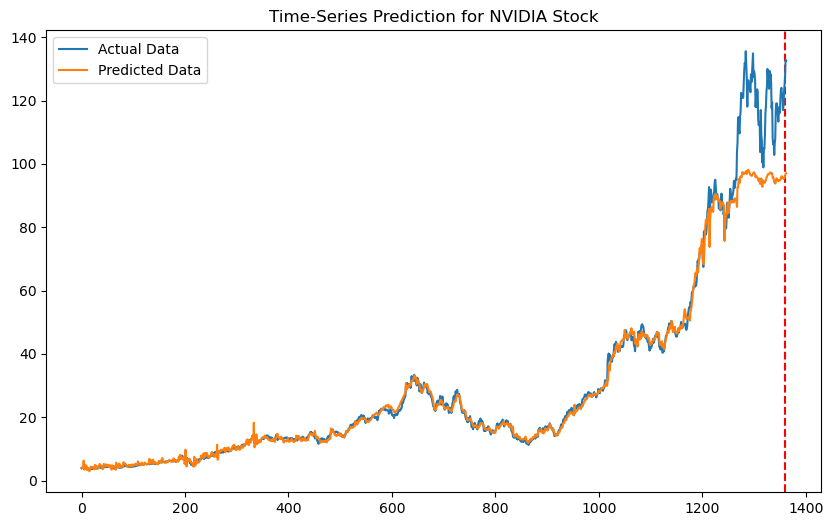
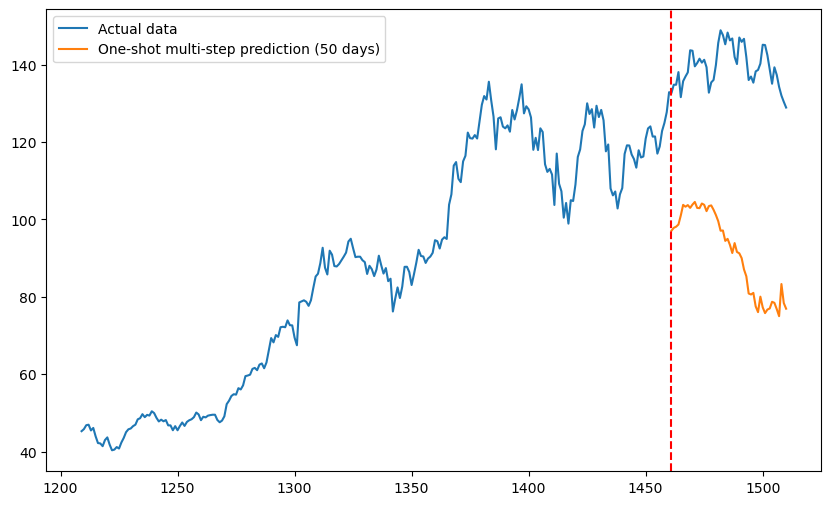

### Task 3

Below is listed images from the predictions and MSE for each model. Task3.py includes the code, which is example from the 

https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

Each model was run several times and results were seemingly similar each run. Based on these results, the LSTM model is the best choice since it mimics the actual data the best and has lowest error. GRU layer resulted each time similar result and always were agressively increasing instead of formatting the seasonal pattern. RNN layer often resulted in linear increasing line as in the image, it clearly predicts small increasing to passenger amounts and is not able to predict the pattern. On the other hand, LSTM was closest to the seasonal pattern, almost in every run it is able to predict the increasing phase correctly but the decreasing often was cut short (as in current image). LSTM can recognize the small seasonal pattern as its prediction regularly goes up and then decreases. LSTM also recognizes the increasing trend in the number of passengers. Batch size could be increased inorder to LSTM to capture longer trends.

GRU:

Mean Squared Error: 167280.4630205942

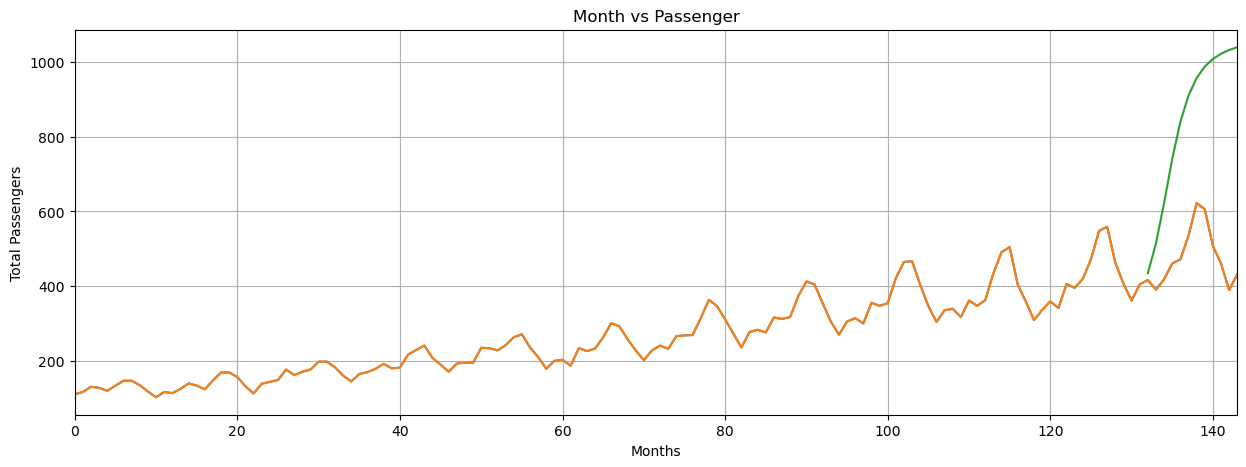

LSTM:

Mean Squared Error: 8318.084062545002

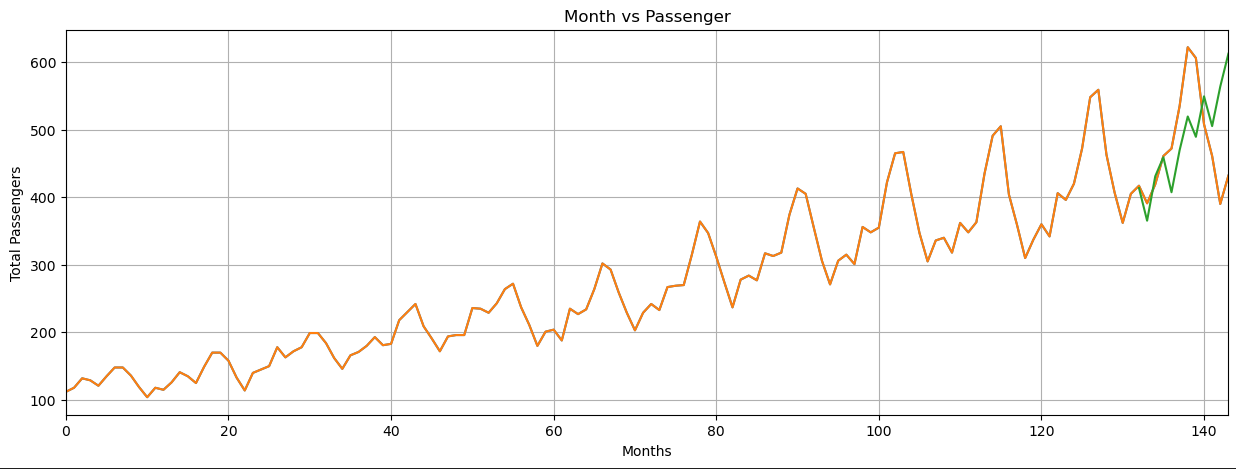

RNN:

Mean Squared Error: 9255.729534496746

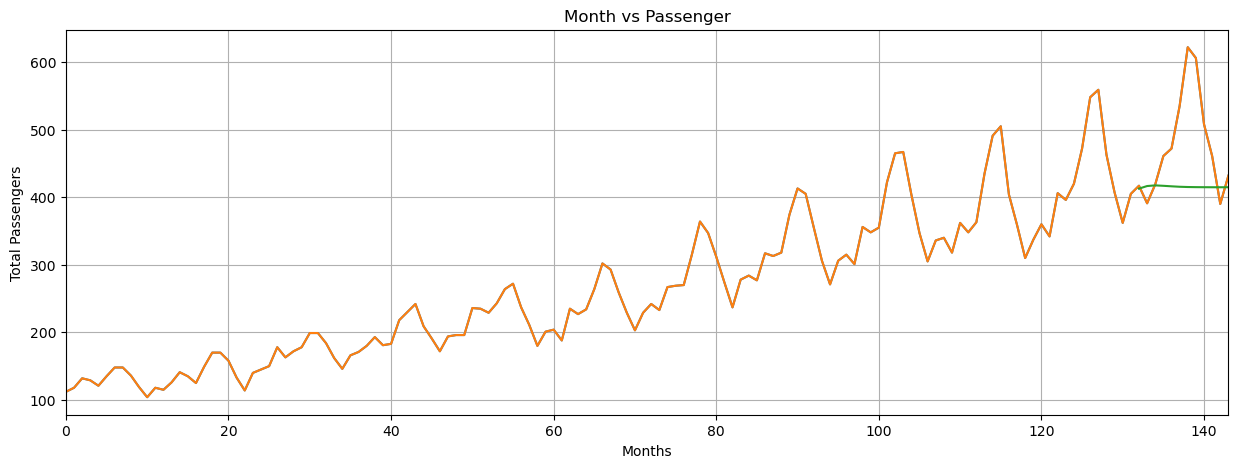

#### Task 4a

**Do the example presented in**

https://www.statology.org/step-by-step-guide-to-linear-regression-in-python/ 

**Return your analysis with images and zipped code.**

**Analysis:**
Model works quite well, MSE error of 0.53 does not seem to high for the data. Thus, there are room for improvement with value range 0-5. The Actual vs Predicted MedHouseVal image gives more insight as it seems to that model work better for small values 0-3 and variance increases radically for 4-5.

Measurements:
- Mean Squared Error: 0.5385446422423641
- R-squared: 0.5966234519623752

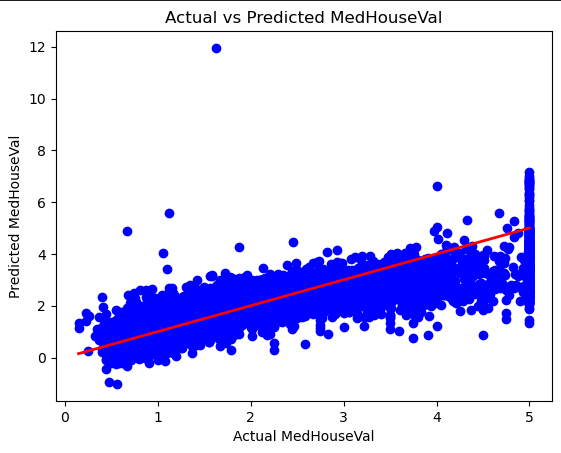

#### Task 4b

**Modify the exercise 2 for this new dataset in link 4a. Compare the results and dataset
from 4a to modified exercise 2 predictor results. Is the linear regressor better than the
LSTM predictor? Return your analysis with images and zipped code.**

Full implementation is in task4.ipynb. Below is analysis part:

Implement LSTM on the dataset. We want to predict MedHousingVal using different features.

Looking closely the data, columns 

- HouseAge      median house age in block group
- AveRooms      average number of rooms per household
- Latitude      block group latitude
- Longitude     block group longitude

are selected for the prediction.

Majority of the MedHouseVals seems to be at 1-2. Which makes the previous linear regression predictions for smaller values more reliable. 

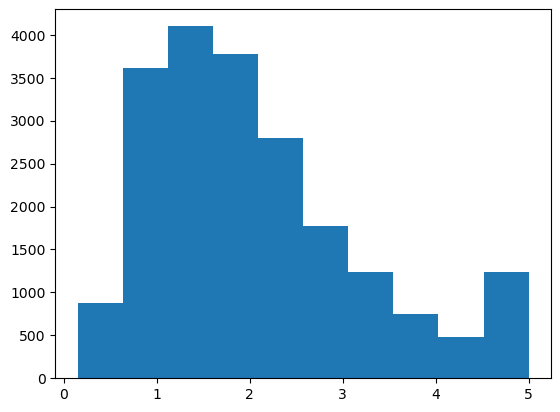

The Task 2 code is implemented on the data. Results:

Error measurements:

- Train MSE: 0.4961, Train R2: 0.6289
- Test MSE: 0.4969, Test R2: 0.6208

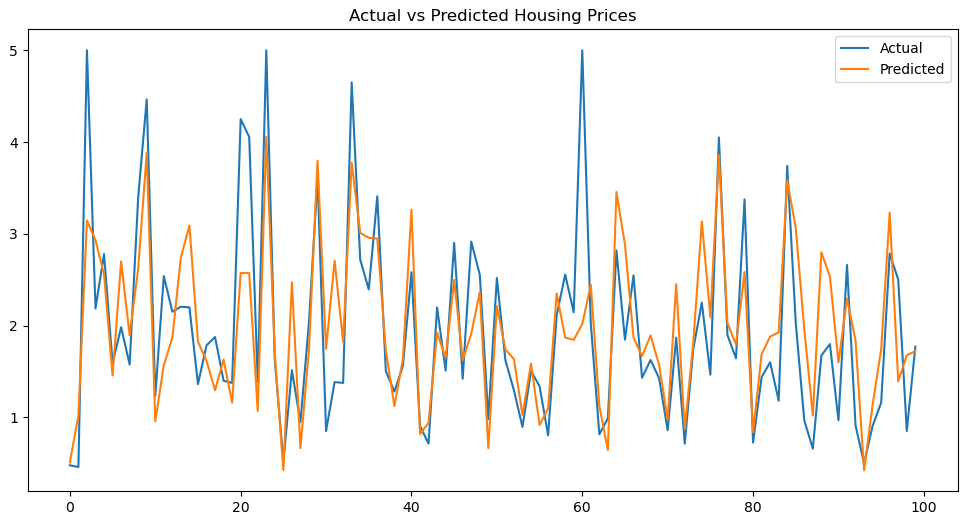

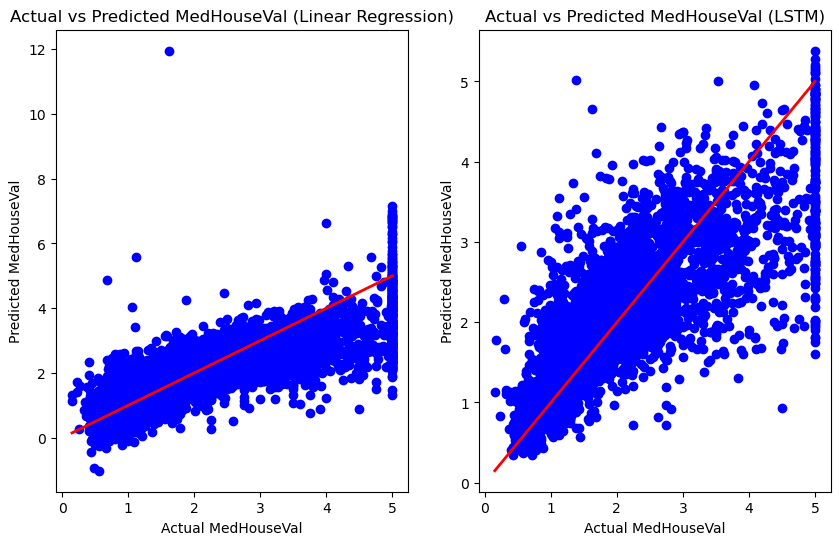

First image shows good results on smaller variety, and large peaks are difficult to predict. Overall, the results on first image are decent.

Based on latter image, the LSTM performs better and specially for larger values (3-5), the predictions are more accurate. This is due to observation that points scatter closer to red line for LSTM than Linear regression. 
LSTM predictor have slightly lower MSE value of 0.5118 (linear 0.5385) and higher R-squared value of 0.5966 (0.6095). These values supports the observations.

For more accurate results, different features should be tested to predict MedHouseVal and optimizations could be made into architecture, since this implementation uses the base model from the task 2 (tutorial).

**Reminder** Linear regressor results:
- Mean Squared Error: 0.5385446422423641
- R-squared: 0.5966234519623752

#### Task 5

**Load the code “Anomaly_detection_autoencoder.py” and the related data ECG5000.zip
as well as the arff2pandas-master.zip. Extract the packages in the same folder where the
anomaly detection python code is.
Run the code and verify that it is working. The running might take time.
Can you improve the already high classification and what you have to change?**

LSTM autoencoder is constructed from two parts, encoder and decoder. Both of these are build using two similar LSTM layers and decoder has additional linear layer after them. Generally its, purpose is to capture long term depencies.

Encoder compresses and reads the input sequence data step by step and encodes the temporal depencies into hidden states.

Decoder reconstructs the sequence from the compressed hidden state and tries to generate similar output, which matches the original input.

Improvement attemp is made using bidirectional = True parameter for the first LSTM layer for both Encoder and Decoder. The second LSTM layer input size needs to be multiplied by two. Bidirectional doubles the hidden state dimension since it makes the model capture depencies in forward and backward directions. Run time for single epoch increased from 22s -> 28s. Around 70 epochs were run before stopping due to bad results. Loss stabled around 17, which indicated that it is not going any lower when comparing to original results (image below).

Additional run was made using linear layer (size of embedding dim) and activation function (ReLU) is added to Encoder after LSTM layers. This could improve results but after 40 epochs the loss stabled in around 40. Linear layer possibly lead to losing key features from the LSTMs.

**Verbally:**
- what is the best strategy to improve the code that is slow in the first place?

Best strategy would be to use algorithm optimization, which runs different setups parameters for model architecture and/or training process. Early stopping method is essential for time saving, where the run is stopped early when live time results are looking worse. These automation optimization may take more time for larger and slower models but they come in hand when finding the most optimal solution. It is more valuable to let machine work for few hours to find optimal solution than manually changing and monitoring training process. 

Deep examination on architecture and dataset may also save time. For example, there are no need for complex and time consuming models if dataset is small and task is simple. 

- In order to save time is there any way to monitor the improvements on the fly?

Simply, the monitor can be made by printing loss values and run times for each epoch (implemented on the anomally_detection_autoencoder.py). Huge and increasing loss can instantly indicate worse results and run can be stopped. Tqdm library is good for monitoring, whereas it can provide information about training times. Monitoring can be further automated and used to stop run early (as previously presented).

Code is run successfully. Outputs are below and model is working as expected when comparing to the tutorial at https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

**Last epoch:**

Epoch 150: train loss 9.13842449030632 val loss 9.52928590286307

**Predictions:**

Correct normal predictions: 141/145
Correct anomaly predictions: 143/145

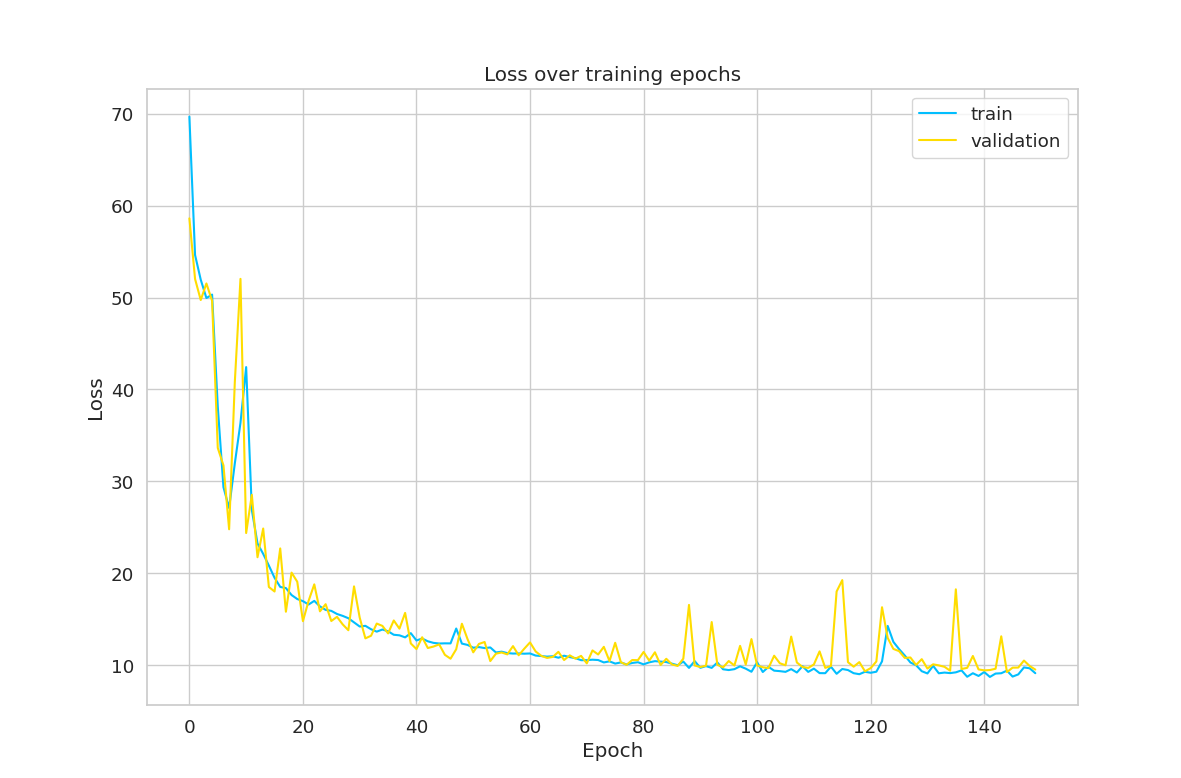

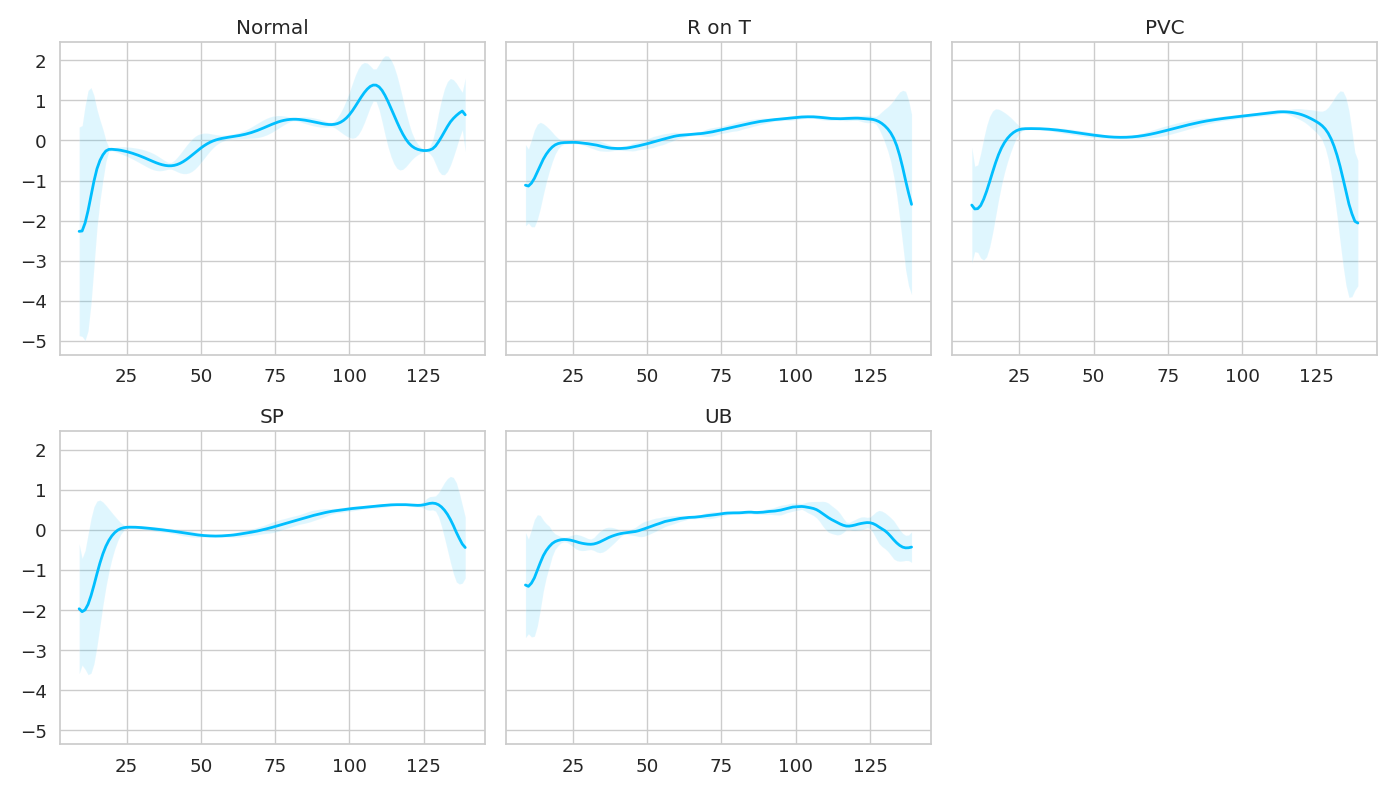